<a href="https://colab.research.google.com/github/AnetaKovacheva/wonders-of-world/blob/main/Wornders_of_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wonders of Universe

This Notebook explores transfer learning with `EfficientNetB3`. The latter is a Deep Convolutional Neural Network Architecture, proposaed in 2020 (see Arxiv paper [here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwidp-nIn5T7AhUuQvEDHdh1DKwQFnoECC8QAQ&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1905.11946&usg=AOvVaw3xdkDI0BEVu5QNHLd4jsV5)). The experiment uses the [Wornders of World](https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification) dataset. Most of the code is taken from a Kaggle user, available [here](https://www.kaggle.com/code/gpiosenka/wonders-f1-score-98).

The workflow and the code is organised into several chapters. The first one loads, presents, and prepares the data. The images are pre-processed in the Second. Thereafter, I build, compile, and train a model. And lastly, model performance is evaluated in Chapter IV.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install visualizing frameworks

In [2]:
!pip install visualkeras
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 30.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage import data, io 
from skimage.color import rgb2gray

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

import visualkeras

In [6]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)

## I. Load and prepare datasets

The Wonders of World dataset contains a total of 3846 images placed in folders, with which each folder representing one of the top new Wonders of the World. The wonders fall in one of the following categories: *Venezuela Angel Falls, Taj Mahal, Stonehenge, Statue of Liberty, Chichen Itz, Christ the Redeemer, Pyramids of Giza, Eiffel Tower, Great Wall of China, Burj Khalifa, Roman Colosseum, Machu Pichu*.

The path to the images is stored in variable.

In [7]:
sdir=r'/content/drive/MyDrive/small_tasks/Wonders of World/Wonders of World'

Define initial height, width, samples, sample_count, and an empty lists to store filepaths and labels. Make a list of classes.

In [8]:
ht = 0
wt = 0
samples = 0
sample_count = 10
filepaths = []
labels = []
classlist = os.listdir(sdir)

Prepare data for further pre-processing. Join name of class to the respective directory, make a list all jpg files, get index and title of file, add each file to the respective class, add the file-paths to the empty list, add the classes to the labels list, and compute cumulative image heigth and width to get average shape of all images.

In [9]:
for klass in classlist:
    classpath = os.path.join(sdir, klass) # path to dir per class
    flist = os.listdir(classpath) # list of all jpg files   
    for i, f in enumerate(flist): # index and file name
        fpath = os.path.join(classpath, f) # add file to respective class
        filepaths.append(fpath) # add filepaths to the empty list
        labels.append(klass) # add classes to the labels list
        #  get image shape to use for averaging of image shapes
        if i < sample_count:
            img = plt.imread(fpath)               
            ht += img.shape[0]
            wt += img.shape[1]
            samples +=1

Put filepaths and labels in pandas DataFrame. Check the number of unique classes.

In [10]:
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
class_count= len(df['labels'].unique())
print('The dataframe has ', class_count, ' classes')

The dataframe has  12  classes


Show the created pandas DataFrame

In [11]:
df.sample(5)

filepaths                 labels
2138  /content/drive/MyDrive/small_tasks/Wonders of ...            machu_pichu
3641  /content/drive/MyDrive/small_tasks/Wonders of ...  venezuela_angel_falls
243   /content/drive/MyDrive/small_tasks/Wonders of ...    christ_the_reedemer
3366  /content/drive/MyDrive/small_tasks/Wonders of ...           chichen_itza
3600  /content/drive/MyDrive/small_tasks/Wonders of ...  venezuela_angel_falls

Split data into train, validation, and test sets. Check number of samples in each set.

In [12]:
train_df, dummy_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 123, stratify = df['labels']) 
valid_df, test_df = train_test_split(dummy_df, train_size = 0.5, shuffle = True, random_state = 123, stratify = dummy_df['labels'])    
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df lenght:  3076   test_df length:  385   valid_df length:  385


Compute number of samples per each class in the train data

In [13]:
classes = list(train_df['labels'].unique()) # make a list of unique labels
class_count = len(classes) # count classes
groups = train_df.groupby('labels') # Groupby samples per label
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in train_df['labels'].unique():
      group = groups.get_group(label)      
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

            CLASS               IMAGE COUNT 
      statue_of_liberty             190     
     great_wall_of_china            314     
    venezuela_angel_falls           201     
         machu_pichu                314     
     christ_the_reedemer            258     
       roman_colosseum              315     
         chichen_itza               272     
       pyramids_of_giza             298     
          taj_mahal                 126     
         burj_khalifa               312     
          stonehenge                163     
         eiffel_tower               313     


Compute average image height and width, and their aspect ratio

In [14]:
wave = wt/samples
have = ht/samples
aspect_ratio = have/wave
print ('Average Image Height: ' , have, '  Average Image Width: ', wave, '  Aspect ratio: ', aspect_ratio)

Average Image Height:  460.98333333333335   Average Image Width:  597.2416666666667   Aspect ratio:  0.7718539396391746


## II. Data pre-processing

Image size is set to (200, 250) since `EfficientNetB3` expects images with this dimension.

In [17]:
img_size = (200, 250)
batch_size = 40 

`ImageDataGenerator` generates batches of tensor image data with real-time data augmentation. `rotation_range` indicates the degree range for random rotations. `width_shift_range` shifts the image to the left or right (horizontal shifts). If the value is float and <=1 it will take the percentage of total width as range. Similarly for `height_shift_range`. `zoom_range` shows the range for random zoom.

In [18]:
trgen = ImageDataGenerator(horizontal_flip = True, rotation_range = 20, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2)

Validation and test images are not subject to shifts, rotations, and flips (`ImageDataGenerator` is instantiated with its default values) - they are shown to the model as they are in real life.

In [19]:
t_and_v_gen = ImageDataGenerator()

`ImageDataGenerator` is applied to the train and test data.

In [20]:
train_gen = trgen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size,
                                   class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size,
                                   class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 3076 validated image filenames belonging to 12 classes.
Found 385 validated image filenames belonging to 12 classes.


For the `test_gen` we want to calculate the batch size and test steps such that `batch_size` * `test_steps` = `number of samples in test set`. This insures that we go through all samples in test set exactly once.

In [21]:
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse = True)[0]  
test_batch_size

77

In [22]:
test_steps = int(length/test_batch_size)
test_steps

5

Apply `ImageDataGenerator` to test data. 

In [23]:
test_gen = t_and_v_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size,
                                   class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = test_batch_size)

Found 385 validated image filenames belonging to 12 classes.


From the generator, we can get information we will need later.

In [24]:
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels

print ('test batch size: ' , test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

test batch size:  77   test steps:  5  number of classes :  12
       class name        class index 
      burj_khalifa            0      
      chichen_itza            1      
   christ_the_reedemer        2      
      eiffel_tower            3      
   great_wall_of_china        4      
       machu_pichu            5      
    pyramids_of_giza          6      
     roman_colosseum          7      
    statue_of_liberty         8      
       stonehenge             9      
        taj_mahal             10     
  venezuela_angel_falls       11     


The function below helps to display some images after data augmentation.

In [25]:
def show_image_samples(gen):
  """
  Displays up to 25 images after data augmentation
  Arguments: Image dataset generated with ImageDataGenerator
  """
  t_dict = gen.class_indices
  classes = list(t_dict.keys())    
  images, labels = next(gen) # get a sample batch from the generator 
  plt.figure(figsize = (20, 20))
  length = len(labels)
  if length < 25:   #show maximum of 25 images
      r = length
  else:
      r = 25
  for i in range(r):        
      plt.subplot(5, 5, i + 1)
      image = images[i] /255       
      plt.imshow(image)
      index = np.argmax(labels[i])
      class_name = classes[index]
      plt.title(class_name, color = 'blue', fontsize = 12)
      plt.axis('off')
  plt.show()

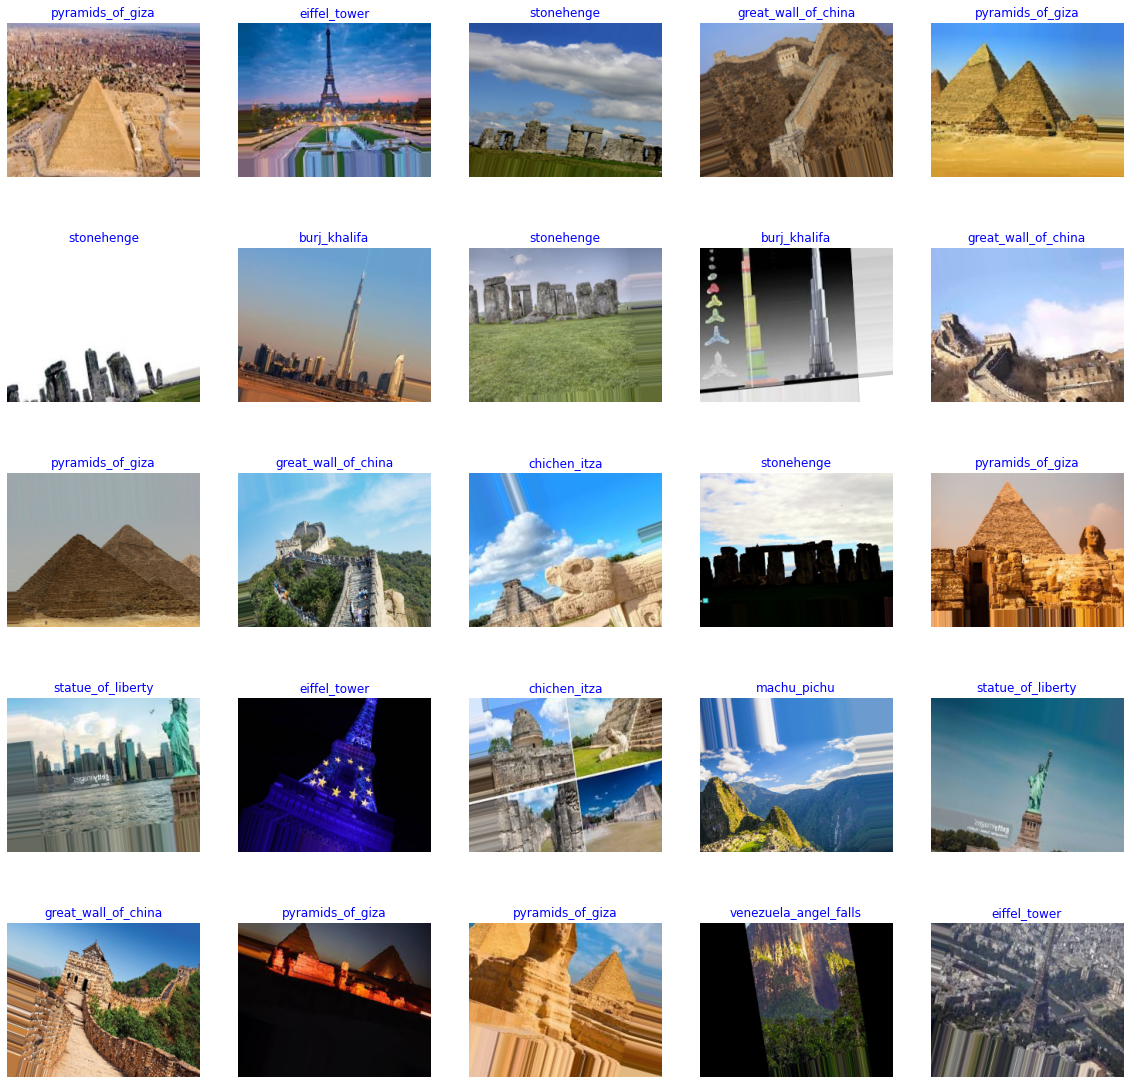

In [26]:
show_image_samples(train_gen)

## III. Build, compile and train a CNN with transfer learning

Transfer learning is a Machine Learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in Deep Learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems ([ref](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)). 

`EfficientNetB3` is used in this exercise. It is loaded and stored in a variable. Several callbacks to monitory and adjust training are defined.  

### III. 1. Constants

In [27]:
img_shape = (img_size[0], img_size[1], 3)
model_name = 'EfficientNetB3'
lr = 0.001
epochs = 40
ask_epoch = 10

### III.2. Load `EfficientNetB3` architecture.

In [28]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max')

43941136/43941136 [==============================] - 3s 0us/step


The `summary()` method displays the model architecture, including the number of parameters.

In [50]:
# base_model.summary()

It should be noted that the general advice is NOT to make the base model trainable initially. It turns out that this is WRONG - a trainable model gives better results.

In [30]:
base_model.trainable = True

### III.3. Build and compile the CNN

The solution published in Kaggle, on top of the `base_model`, adds `BatchNormalization` layers, regularized `Dense` layers with 1024 and 128 neurons respectively, followed by `Dropout` layers, and ends with a `Dense` layer with 12 neurons (as the number of classes).

In [31]:
x = base_model.output
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate = 0.3, seed = 123)(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate = 0.45, seed = 123)(x)        
output = Dense(class_count, activation ='softmax')(x)

In [32]:
model = Model(inputs = base_model.input, outputs = output)

It is interesting to note that instead of `Adam`, this CNN solves the problem with `Adamax` - a variant of `Adam` based on the infinity norm.

In [33]:
model.compile(Adamax(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])

### III.4. Explore model architecture

This part explores layers' weights. Greater weights suggest holding more information. However, the information they hold would be useless if these layers produce zero-activations. Therefore, layers with the largest number of weights in selected convolutional blocks are examined below. To that end, a variable holding these layers' index is initiated (layers_to_examine). Prior to that layers indices and names are displayed.

In [34]:
[(index, layer.name) for (index, layer) in enumerate(model.layers)]

[(0, 'input_1'),
 (1, 'rescaling'),
 (2, 'normalization'),
 (3, 'tf.math.truediv'),
 (4, 'stem_conv_pad'),
 (5, 'stem_conv'),
 (6, 'stem_bn'),
 (7, 'stem_activation'),
 (8, 'block1a_dwconv'),
 (9, 'block1a_bn'),
 (10, 'block1a_activation'),
 (11, 'block1a_se_squeeze'),
 (12, 'block1a_se_reshape'),
 (13, 'block1a_se_reduce'),
 (14, 'block1a_se_expand'),
 (15, 'block1a_se_excite'),
 (16, 'block1a_project_conv'),
 (17, 'block1a_project_bn'),
 (18, 'block1b_dwconv'),
 (19, 'block1b_bn'),
 (20, 'block1b_activation'),
 (21, 'block1b_se_squeeze'),
 (22, 'block1b_se_reshape'),
 (23, 'block1b_se_reduce'),
 (24, 'block1b_se_expand'),
 (25, 'block1b_se_excite'),
 (26, 'block1b_project_conv'),
 (27, 'block1b_project_bn'),
 (28, 'block1b_drop'),
 (29, 'block1b_add'),
 (30, 'block2a_expand_conv'),
 (31, 'block2a_expand_bn'),
 (32, 'block2a_expand_activation'),
 (33, 'block2a_dwconv_pad'),
 (34, 'block2a_dwconv'),
 (35, 'block2a_bn'),
 (36, 'block2a_activation'),
 (37, 'block2a_se_squeeze'),
 (38, 'b

In [35]:
layers_to_examine = [16, 30, 143, 378, 389]

Weights distribution in the selected layers is displayed below. Values on $x$ axis are limited in the range [-0.5, 0.5] to enable comparisons. Restricting  $y$ values does not make sense.

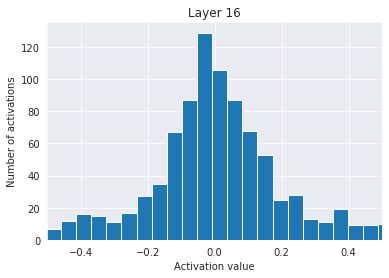

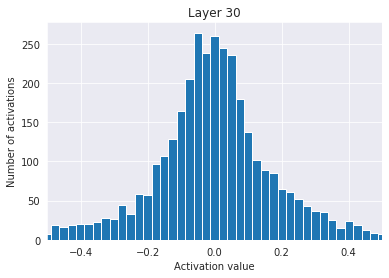

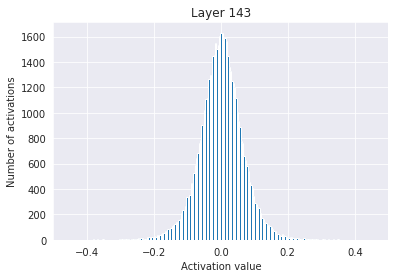

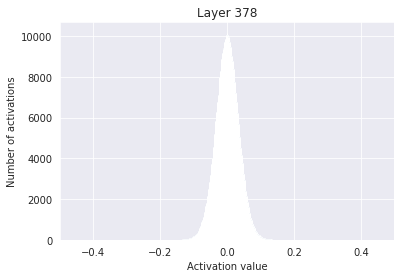

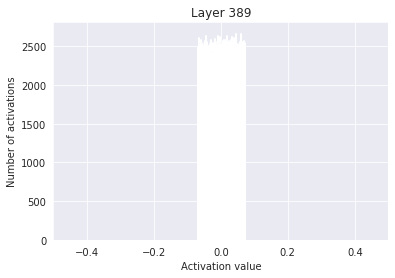

In [36]:
for i in layers_to_examine:
    plt.figure(figsize = (6, 4))
    plt.hist(model.layers[i].kernel.numpy().ravel(), bins = "fd")
    plt.xlim(-0.5, 0.5)
    plt.title(f"Layer {i}")
    plt.xlabel("Activation value")
    plt.ylabel("Number of activations")
    plt.show()

There are smaller number of weights in lower layers. Their values' distribution is broader; more and more activations get closer to zero over time. Thus, regardless of weights’ large number in upper layers, it seems the neurons they are associated with does not play a role for computing activations. On the other hand, weights' values in the last `Dense` layer (no. 389) are randomly distributed. The latter confims this layer was not subject to training.

Model architecture is displayed below - as a 3D image, and a graph.

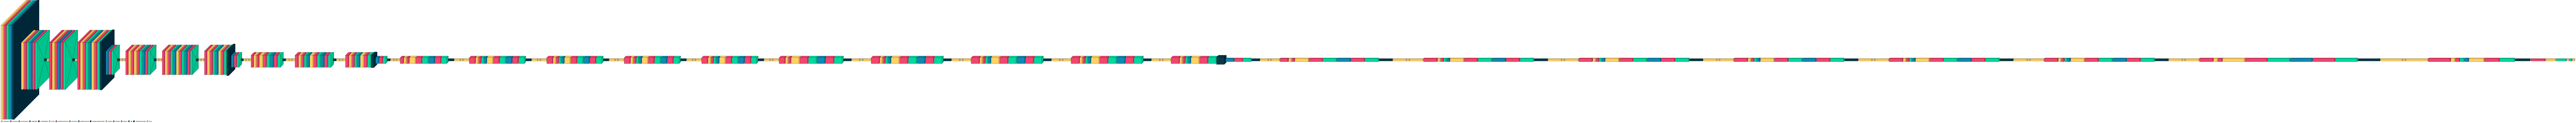

In [37]:
visualkeras.layered_view(model, legend = True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.755975 to fit



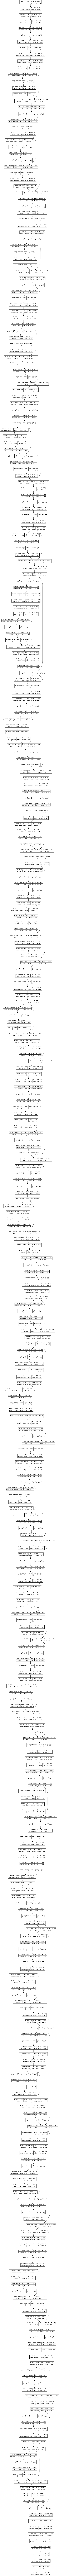

In [38]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = False,
                          show_layer_names = True, rankdir = "TB", expand_nested = True, dpi = 96,
                          layer_range = None, show_layer_activations = True)

### III.5. Define callbacks

The class below creates a callback to ask if model training should continue after certain number of epochs, or not.

In [39]:
#@title `ASK` callback
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

Set up `ask` callback, as well as `EarlyStopping` and `ReduceLROnPlateau`. The latter reduces the learning rate if validation loss does not go down for 4 consequtive epochs.

In [40]:
ask = ASK(model, epochs,  ask_epoch)
rlronp = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2,verbose = 1)
estop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 4, verbose = 1, restore_best_weights = True)
callbacks=[rlronp, estop, ask]

### III.6. Train the model

The model is trained on the train set, and validated on the validation set for at least 10 epochs, but not more than 40 epochs. All three callbacks are put in place.

In [41]:
history=model.fit(x = train_gen,  epochs = epochs, verbose = 1, callbacks = callbacks,  validation_data = valid_gen,
                 shuffle = False,  initial_epoch = 0) 

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
77/77 [==============================] - 142s 2s/step - loss: 23.0677 - accuracy: 0.6928 - val_loss: 20.0003 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 2/40
77/77 [==============================] - 81s 1s/step - loss: 14.8215 - accuracy: 0.9213 - val_loss: 12.3290 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 3/40
77/77 [==============================] - 80s 1s/step - loss: 10.1405 - accuracy: 0.9574 - val_loss: 8.2872 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 4/40
77/77 [==============================] - 80s 1s/step - loss: 7.0845 - accuracy: 0.9733 - val_loss: 5.7972 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 5/40
77/77 [==============================] - 79s 1s/step - loss: 5.0455 - accuracy: 0.9776 - val_loss: 4.1625 - val_accuracy: 0.9818 - lr: 0.0010
Epoch 6/40
77/77 [==============================] - 79s 1s/step - l

## IV. Evaluate model performance

Model performance is evaluated by displaying train and validation loss and accuracy, with confussion matrix, and classification report.

The plots below show how train and validation loss and accuracy change (diminish) over time. Curves on both plots confirm that the Neural Network does not overfit the train data.

In [42]:
#@title Plot train and validation `loss` and `accuracy`
def tr_plot(tr_data, start_epoch):
  """
  Plots training and validation curve 
  Arguments: train history, and start epoch
  Displays train and validation loss and accuracy
  """
  #Plot the training and validation data
  tacc=tr_data.history['accuracy']
  tloss=tr_data.history['loss']
  vacc=tr_data.history['val_accuracy']
  vloss=tr_data.history['val_loss']
  Epoch_count=len(tacc)+ start_epoch
  Epochs=[]
  for i in range (start_epoch, Epoch_count):
      Epochs.append(i+1)   
  index_loss = np.argmin(vloss)#  this is the epoch with the lowest validation loss
  val_lowest = vloss[index_loss]
  index_acc = np.argmax(vacc)
  acc_highest = vacc[index_acc]
  plt.style.use('fivethirtyeight')
  sc_label = 'best epoch= '+ str(index_loss +1 + start_epoch)
  vc_label = 'best epoch= '+ str(index_acc + 1 + start_epoch)
  fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))
  axes[0].plot(Epochs, tloss, 'r', label = 'Training loss')
  axes[0].plot(Epochs, vloss, 'g', label = 'Validation loss')
  axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s = 150, c = 'blue', label = sc_label)
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[1].plot(Epochs, tacc, 'r', label = 'Training Accuracy')
  axes[1].plot(Epochs, vacc, 'g', label = 'Validation Accuracy')
  axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s = 150, c = 'blue', label = vc_label)
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()
  plt.tight_layout    
  plt.show()

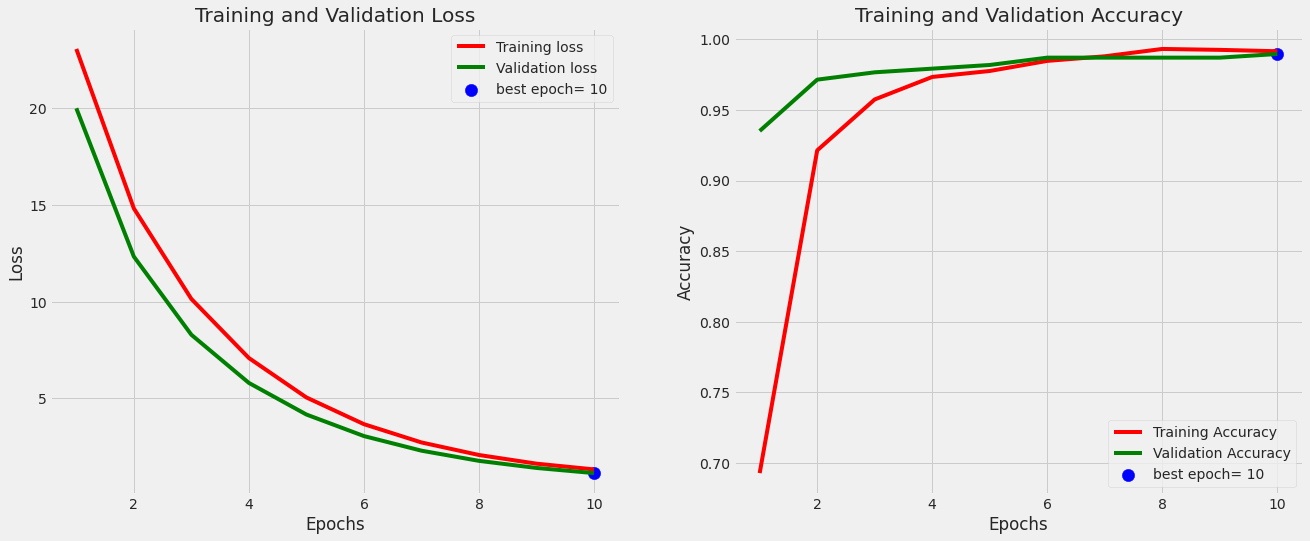

In [43]:
tr_plot(history, 0)

#### IV.2. Predict class of test data

Test images are passed to the model to predict their label.

In [44]:
y_pred = []
y_true = test_gen.labels
errors = 0
preds = model.predict(test_gen, steps = test_steps, verbose = 1) # predict on the test set
tests = len(preds)

5/5 [==============================] - 11s 2s/step


The codel lines below get the index of each prediction and store it in a variable.

In [45]:
for i, p in enumerate(preds):
        pred_index = np.argmax(p)         
        true_index = test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred                                           
            errors = errors + 1
        y_pred.append(pred_index)

### IV.3. Plot confusion matrix

The confusion matrix shows Actual and Predicted Positive (True) and Negative (False) predictions. It needs true and predicted classes of samples in the test data. The first code line below shows that only 3 samples out of 385 were misclassifiedz, which results in 99.22% accuracy - quite a good performance of the model.

In [46]:
acc = (1 - errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred = np.array(y_pred)
ytrue = np.array(y_true)
cm = confusion_matrix(ytrue, ypred)

there were 3 in 385 tests for an accuracy of  99.22


The three wrongly predicted images could be seen on the confusion matrix below. They are indicated with $1$.

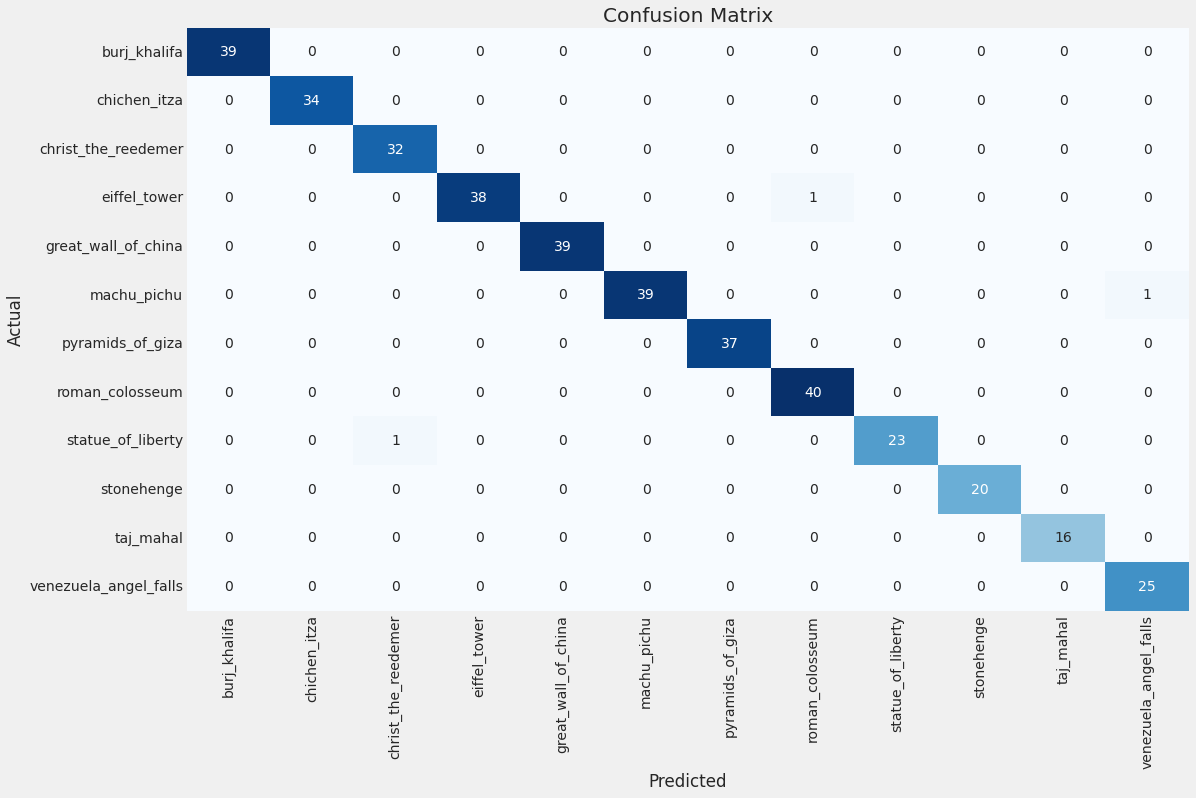

In [47]:
plt.figure(figsize = (16, 10))
sns.heatmap(cm, annot = True, vmin = 0, fmt = 'g', cmap = 'Blues', cbar = False)       
plt.xticks(np.arange(class_count) + 0.5, classes, rotation = 90)
plt.yticks(np.arange(class_count) + 0.5, classes, rotation = 0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### IV.4. Classification report

Similarly, the Classification report shows `precision`, `recall` and `f1 score` for each class. The figures confirm that most images were properly classified.

In [48]:
clr = classification_report(y_true, y_pred, target_names = classes, digits = 4)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                        precision    recall  f1-score   support

         burj_khalifa     1.0000    1.0000    1.0000        39
         chichen_itza     1.0000    1.0000    1.0000        34
  christ_the_reedemer     0.9697    1.0000    0.9846        32
         eiffel_tower     1.0000    0.9744    0.9870        39
  great_wall_of_china     1.0000    1.0000    1.0000        39
          machu_pichu     1.0000    0.9750    0.9873        40
     pyramids_of_giza     1.0000    1.0000    1.0000        37
      roman_colosseum     0.9756    1.0000    0.9877        40
    statue_of_liberty     1.0000    0.9583    0.9787        24
           stonehenge     1.0000    1.0000    1.0000        20
            taj_mahal     1.0000    1.0000    1.0000        16
venezuela_angel_falls     0.9615    1.0000    0.9804        25

             accuracy                         0.9922       385
            macro avg     0.9922    0.9923    0.9921       385
      

In [49]:
# Save the model
# working_dir=r'./'

# subject='world wonders' 
# acc=str(( 1-errors/tests) * 100)
# index=acc.rfind('.')
# acc=acc[:index + 3]
# save_id= subject + '_' + str(acc) + '.h5' 
# model_save_loc=os.path.join(working_dir, save_id)
# model.save(model_save_loc)
# print ('model was saved as ' , model_save_loc ) 